In [1]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
from matplotlib.patches import ConnectionPatch
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch
from sunpy.map import Map
from aiapy.calibrate import register

%matplotlib inline

# Plotting: Some "Advanced" Examples

This notebook contains a few examples of more advanced plotting features with matplotlib and wcsaxes. These may be useful for producing publication-quality plots of AIA image data.

## Multiple AIA Images in a Single Figure

This example shows how to plot AIA images from multiple wavelengths, all of which have been cropped to the same active region, in different panes in a single figure.

First, read in the data and register each image such that the y-axis of each image is aligned with solar north and has the same resolution (0.6 arcseconds per pixel).

In [2]:
files = [
    '../data/aia_lev1_94a_2012_02_11t15_00_02_12z_image_lev1.fits',
    '../data/aia_lev1_131a_2012_02_11t15_00_09_62z_image_lev1.fits',
    '../data/aia_lev1_171a_2012_02_11t15_00_00_35z_image_lev1.fits',
    '../data/aia_lev1_193a_2012_02_11t15_00_07_84z_image_lev1.fits',
    '../data/aia_lev1_211a_2012_02_11t15_00_00_62z_image_lev1.fits',
    '../data/aia_lev1_335a_2012_02_11t15_00_03_62z_image_lev1.fits',
]

In [3]:
maps = [register(Map(f), use_scipy=True) for f in files]

Let's first plot the full-disk map to figure out where we want to crop our map. We can draw a rectangle around the active region of interest using the `.draw_rectangle` method.

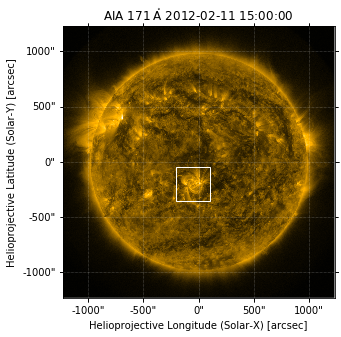

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection=maps[2])
maps[2].plot()
# The order is bottom left, width, height
maps[2].draw_rectangle(
    SkyCoord(-200*u.arcsec,-350*u.arcsec,frame=maps[2].coordinate_frame),
    300*u.arcsec,
    300*u.arcsec,
    color='w'
)

Crop each of our maps using the bounding box above.

In [5]:
maps = [m.submap(SkyCoord(-200*u.arcsec,-350*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(100*u.arcsec,-50*u.arcsec,frame=m.coordinate_frame))
        for m in maps]

Now, let's plot all of our submaps by adding a new axis to the figure for each channel with the `add_subplot` command.

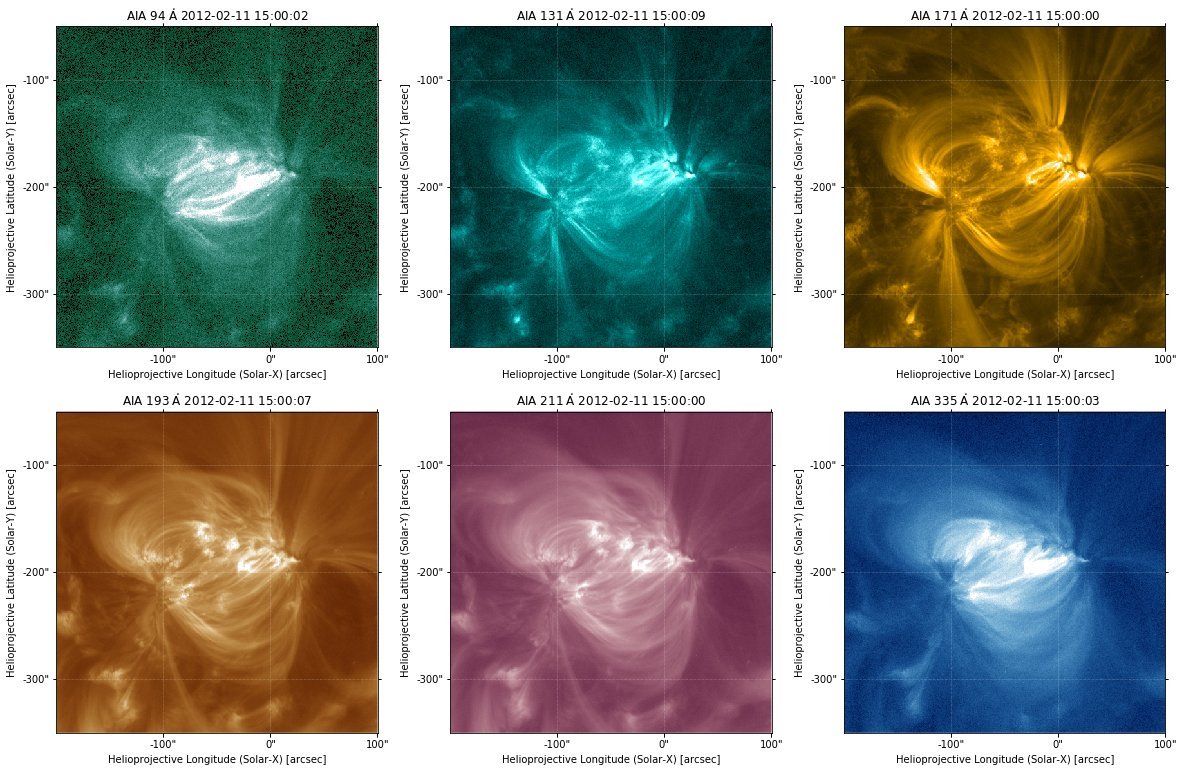

In [6]:
fig = plt.figure(figsize=(20,13))
for i,m in enumerate(maps):
    norm = ImageNormalize(vmin=0,vmax=0.5*m.data.max(),stretch=SqrtStretch())
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(norm=norm)

All of our images are there, but we have a lot of junk leftover. All of our images were taken at the same time and are in the same coordinate system (approximately) so we do not need to include the axes and tick labels on each subplot. Additionally, the repeated titles are a bit cluttered.

Let's clean this up by removing the ticks and axes labels on all plots except the outer ones, remove the titles, placing wavelength labels inside the plot, adding a colorbar for each panel, and moving all the panels closer together.

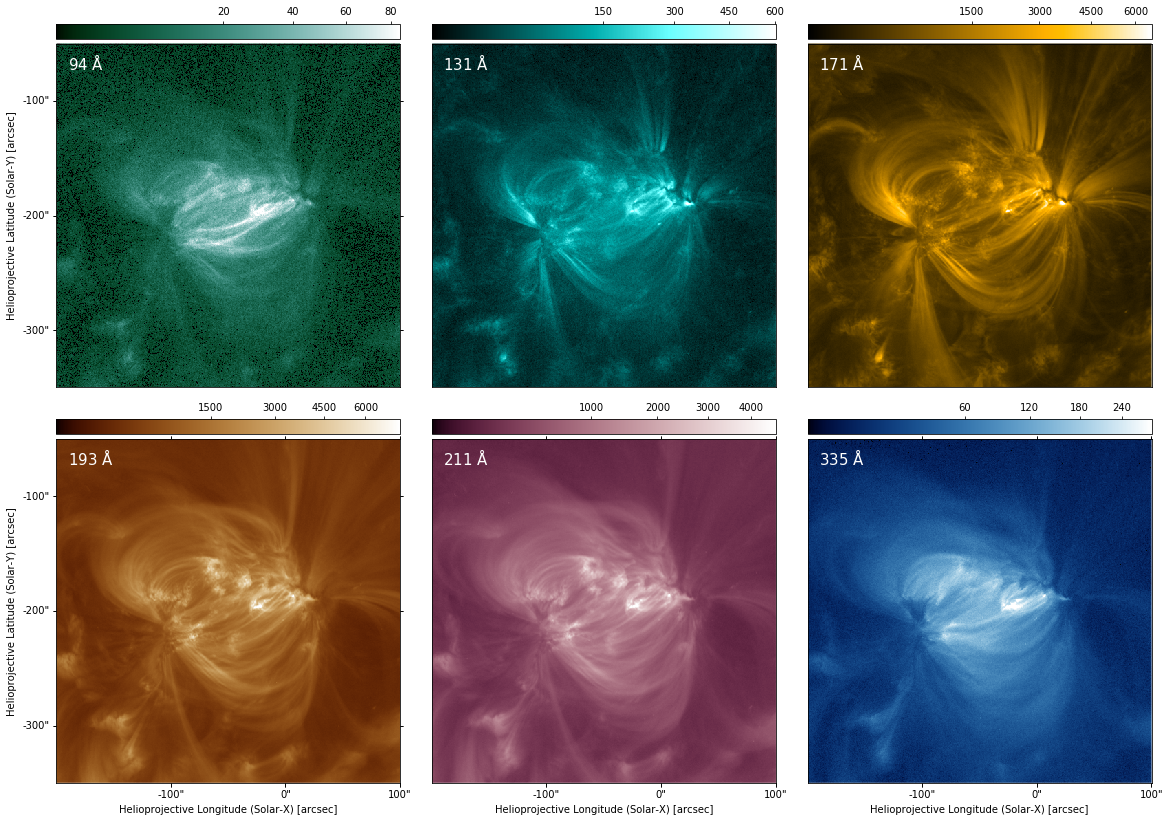

In [7]:
fig = plt.figure(figsize=(20,13.6))
# Adjust horizontal and vertical space between panels
plt.subplots_adjust(hspace=0.15,wspace=0.03)
for i,m in enumerate(maps):
    norm = ImageNormalize(vmin=0, vmax=0.75*m.data.max(), stretch=SqrtStretch())
    # Add a a new axis for each map (channel)
    ax = fig.add_subplot(2,3,i+1,projection=m)
    im = m.plot(norm=norm,title=False,annotate=True)
    # Turn off the helioprojective gridlines
    ax.grid(False)
    lon,lat = ax.coords
    # Remove the longitude ticks/labels for the top row
    if i < 3:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    # Remove the latitude ticks/labels for all columns except the first
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    # Find the pixel location of the channel label
    x,y = m.world_to_pixel(
        SkyCoord(-190*u.arcsec, -75*u.arcsec, frame=m.coordinate_frame))
    # Add wavelength label as text on the plot at (-190", -75")
    ax.text(x.value, y.value,
            f'{m.wavelength.value:.0f} $\mathrm{{\AA}}$',
            color='w',
            fontsize=15,
            horizontalalignment='left',
            verticalalignment='bottom')
    # Add a colorbar for each plot
    # The ax.get_position allows us to position each colorbar exactly
    # over that subplot
    pos = ax.get_position().get_points()
    # Creat a separate axis for the colorbar, specifying the position
    # The order is: x position of bottom left corner,
    #               y position of bottom left corner
    #               width
    #               height
    cax = fig.add_axes([pos[0,0], pos[1,1]+0.005, pos[1,0]-pos[0,0], 0.015])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.locator = matplotlib.ticker.MaxNLocator(nbins=5, prune='lower')
    cbar.update_ticks()
    cbar.ax.xaxis.set_ticks_position('top')


## "Zooming in" to an Active Region in HMI

First, create a `Map`

In [8]:
magnetogram = Map('../data/hmi_m_45s_2019_01_24_14_03_00_tai_magnetogram.fits')

In [9]:
magnetogram = magnetogram.rotate(order=3)

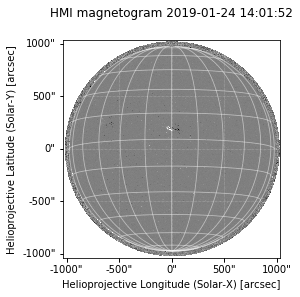

In [10]:
magnetogram.plot(vmin=-7.5e2,vmax=7.5e2)
magnetogram.draw_grid()

Next, define the bounding box of AR 12733

In [11]:
l_corner = SkyCoord(Tx=-142*u.arcsec,
                    Ty=50*u.arcsec,
                    frame=magnetogram.coordinate_frame)
r_corner = SkyCoord(Tx=158*u.arcsec,
                    Ty=350*u.arcsec,
                    frame=magnetogram.coordinate_frame)

And create a submap around the AR

In [12]:
m_small = magnetogram.submap(l_corner, r_corner)

In the large submap, we want to mask all the data that's not on disk. We can do this by computing the limb in pixel spacing and masking all pixels outside that radius.

In [13]:
magnetogram = magnetogram.resample((1000,1000)*u.pixel)

In [14]:
x, y = np.meshgrid(*[np.arange(v.value) for v in magnetogram.dimensions]) * u.pixel
hpc_coords = magnetogram.pixel_to_world(x, y)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / magnetogram.rsun_obs
mask = np.ma.masked_greater(r, 1)

We can then create a new map, this time passing in the mask with the `mask` kwarg.

In [15]:
m_big = Map(magnetogram.data, magnetogram.meta, mask=mask.mask)

Finally, let's build the figure.

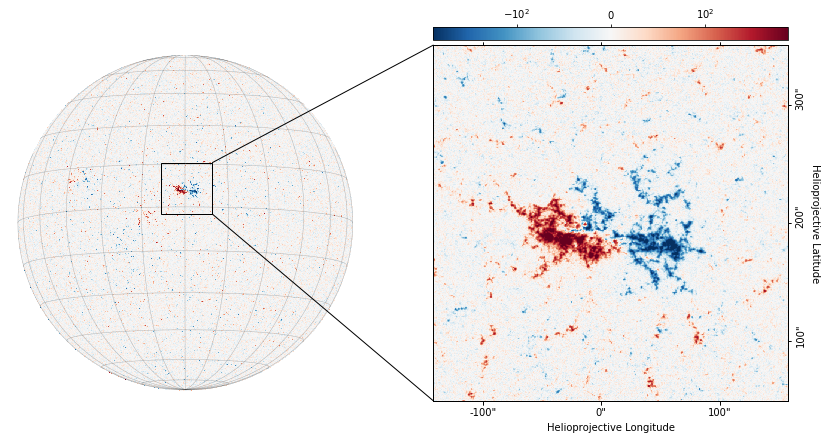

In [16]:
# Setup figure
fig = plt.figure(figsize=(14,7))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

# Plot the first magnetogram
ax1 = fig.add_subplot(121, projection=m_big)
m_big.plot(axes=ax1, cmap='RdBu_r', norm=norm, annotate=False,)
lon,lat = ax1.coords[0], ax1.coords[1]
# Remove the frame and all ticks and ticklabels
lon.frame.set_linewidth(0)
lat.frame.set_linewidth(0)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
# Draw a box around the AR
m_big.draw_rectangle(l_corner, # coordinate of the bottom left corner
                     r_corner.Tx-l_corner.Tx, #width
                     r_corner.Ty-l_corner.Ty, #height
                     color='k',
                     lw=1)
# Draw the heliographic stonyhurst grid
m_big.draw_grid(axes=ax1, color='k', alpha=0.25, lw=0.5)

# Plot the zoomed-in magnetogram
ax2 = fig.add_subplot(122, projection=m_small)
im = m_small.plot(axes=ax2, norm=norm, cmap='RdBu_r', annotate=False,)
ax2.grid(False)  # This removes the HPC grid lines
# Setup ticks and axes labels
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lat.set_ticklabel(rotation='vertical',)
lon.set_axislabel('Helioprojective Longitude',)
lat.set_axislabel('Helioprojective Latitude',)
# Place latitude axis label, ticks, and ticklabels on the right side
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# Add connectors between full-disk and submap
# Top connector line
xpix, ypix = m_big.world_to_pixel(r_corner)
con1 = ConnectionPatch(
    (0,1),
    (xpix.value, ypix.value),
    'axes fraction',
    'data',
    axesA=ax2,
    axesB=ax1,
    arrowstyle='-',
    color='k',
    lw=1,
)
# Bottom connector line
xpix, ypix = m_big.world_to_pixel(SkyCoord(r_corner.Tx,
                                           l_corner.Ty,
                                           frame=m_big.coordinate_frame))
con2 = ConnectionPatch(
    (0,0),
    (xpix.value,ypix.value),
    'axes fraction',
    'data',
    axesA=ax2,
    axesB=ax1,
    arrowstyle='-',
    color='k',
    lw=1,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

# Add colorbar
# Use this to get it precisely over the submap
pos = ax2.get_position().get_points()
cax = fig.add_axes([
    pos[0,0],
    pos[1,1]+0.01,  # pad a bit to lift off the top of the plot
    pos[1,0]-pos[0,0],  # width of the plot
    0.025,
])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.locator = matplotlib.ticker.FixedLocator([-1e2,0,1e2])
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position('top')